상관분석은 두 변수가 함께 움직이는 정도를 숫자로 요약해 관계의 방향과 강도를 확인하는 절차
상관분석을 통해 두 변수 간의 선형관계 여부를 통계적으로 검정할 수 있으며, 데이터 간 연관성을 빠르게 파악할 수 있다.
*상관관계가 있다고 해서 인과관계가 있는 것은 아니다!

In [2]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr


In [3]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

In [4]:
origin = load_data('language_math_scores')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab11_/language_math_scores.xlsx
[desc] 어느 학급의 언어영역과 수리영역 점수를 기록한 가상의 데이터 셋

field     type    description
--------  ------  -------------
언어영역  INT     언어영역 점수
수리영역  INT     수리영역 점수


===== 데이터 크기 확인 =====
데이터셋 크기: (50, 2)
열 개수: 2
행 개수: 50

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   언어영역    50 non-null     int64
 1   수리영역    50 non-null     int64
dtypes: int64(2)
memory usage: 932.0 bytes
None


,언어영역,수리영역
0,66,66
1,58,70
2,73,74
3,52,58
4,72,79


# 상관분석의 가정

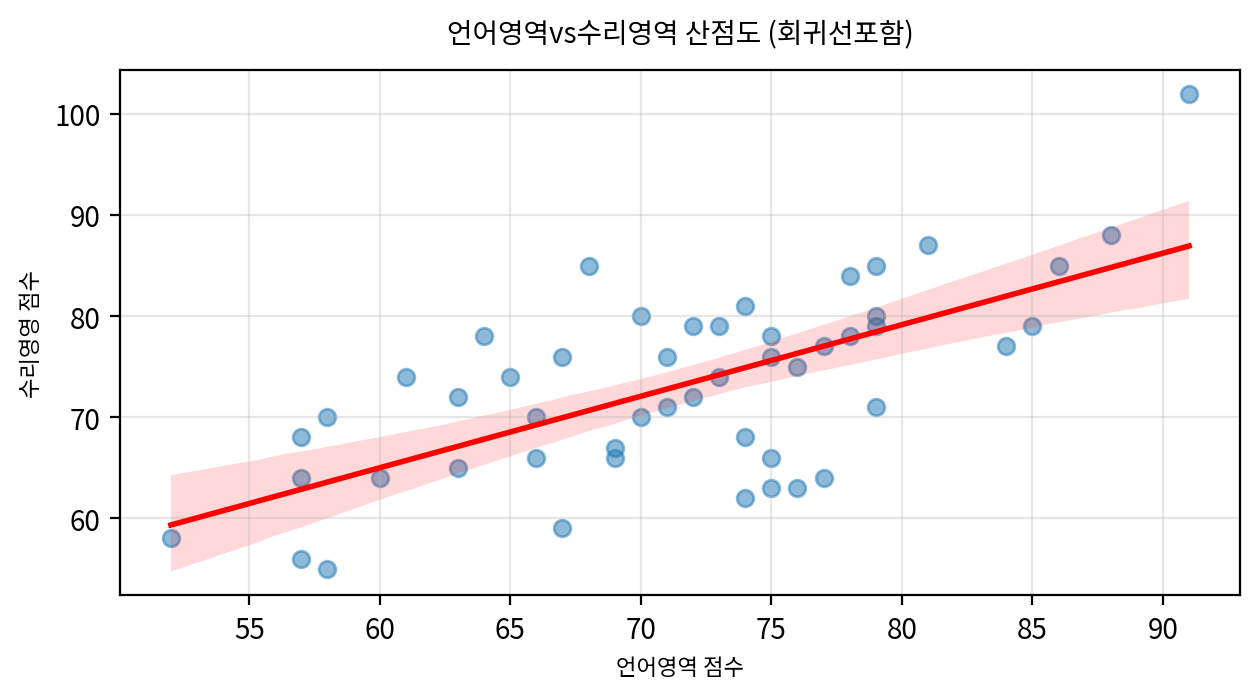

In [22]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

# Scatter Plot그리기(회귀선 포함)
sb.regplot(data=origin, x='언어영역',y='수리영역',scatter_kws={'alpha':0.5}, line_kws = {'color':'red', 'linewidth':2})


ax.set_title('언어영역vs수리영역 산점도 (회귀선포함)', fontsize=10, pad=10)
ax.set_xlabel('언어영역 점수', fontsize=8)
ax.set_ylabel('수리영영 점수', fontsize=8)

ax.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()
plt.close()

점들이 대체로 우상향하는 패턴을 보임
빨간색 회귀선을 중심으로 점들이 모여 잇어 선형 관계가 있어 보임
이는 언어영역 점수가 높을수록 수리영역 점수도 높아지는 양의 상관관계를 시사함.
하지만 눈으로만 판단하면 주관적일 수 있으므로, 통계적 검정을 통해 선형성을 확인해야 함.

In [6]:
x = origin['언어영역']
y = origin['수리영역']

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
reset = linear_reset(model, power=2, use_f=True)

#선형성 적합 여부 (True=적합, False=부적합)
linearity_ok = reset.pvalue>0.05

print(f"Ramsey RESET Test : {'선형성 적합' if linearity_ok else '선형성 위반'} (p-value: {reset.pvalue:.4f})")

Ramsey RESET Test : 선형성 적합 (p-value: 0.1884)


In [8]:
#이상치와 왜도 검정
data = origin[['언어영역', '수리영역']]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    # 왜도 계산
    skew_original = temp.skew()

    #Z-score 기반 이상치 탐지(|z|>3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores)>3))

    #로그 변환 후 왜도 계산 (음수 대비 +1)
    data_log = np.log1p(temp-temp.min()+1)
    skew_log = data_log.skew()

    #로그 변환 필요 여부 판단
    need_log = (abs(skew_original)>1) and (abs(skew_log)<abs(skew_original))
    
    results[col] = {
        'original_skew':skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)':outlier_count,
        'log_recommended': need_log,
    }

results_df = pd.DataFrame(results).T
display(results_df)

#이상치 점검 결과
outlier_flag = len((results_df['outliers(|z|>3)']>0))>0
if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")

,original_skew,log_skew,outliers(|z|>3),log_recommended
언어영역,-0.102559,-1.735952,0,False
수리영역,0.367414,-1.529107,1,False


이상치가 발견되어 스피어만 상관계수 사용


# 상관분석

1. 피어슨 상관계수

In [9]:
pearson_r, pearson_p = pearsonr(origin['언어영역'], origin['수리영역'])
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(pearson_r, pearson_p,  "대립" if pearson_p <= 0.05 else "귀무")

'statistic: 0.671, p-value: 0.000, 대립가설 채택'

2.스피어만 상관계수

In [11]:
spearman_r, spearman_p = spearmanr(origin['언어영역'], origin['수리영역'])
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(spearman_r, spearman_p,  "대립" if spearman_p <= 0.05 else "귀무")

'statistic: 0.599, p-value: 0.000, 대립가설 채택'

가정에 따른 상관계수 선택!
선형 + 왜도/이상치 영향 적음 → 피어슨 우선

단조 비선형 또는 이상치 많음/왜도 큼 → 스피어만 우선

In [13]:
# 1.상관계수 선택
if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearson_r, pearson_p
    rationale = '선형성 만족 + 왜도/이상치 영향 작음으로 판단'

else:
    chosen = 'spearman'
    corr, pval =spearman_r, spearman_p
    rationale = '비선형(또는 이상치 영향) 가능성 고려'

print('=' * 50)
print('📊 상관계수 요약')
print('=' * 50)
print(f"Pearson r: {pearson_r:.3f}, p-value: {pearson_p:.4f}")
print(f"Spearman rho: {spearman_r:.3f}, p-value: {spearman_p:.4f}")

print('\n' + '=' * 50)
print('✅ 최종 선택 결과')
print('=' * 50)
print(f"선택된 방법: {chosen}")
print(f"상관계수: {corr:.3f}")
print(f"p-value: {pval:.4f}")
print(f"선택 근거: {rationale}")
print('=' * 50)


📊 상관계수 요약
Pearson r: 0.671, p-value: 0.0000
Spearman rho: 0.599, p-value: 0.0000

✅ 최종 선택 결과
선택된 방법: spearman
상관계수: 0.599
p-value: 0.0000
선택 근거: 비선형(또는 이상치 영향) 가능성 고려


# 상관행렬

상관행렬은 여러 변수들 간의 상관계수를 한눈에 볼 수 있도록 정리한표

특징
1.행과 열에 같은 변수들이 배치
2.대각선 값은 항상 1(자기 자신과의 상관계수)
3.대칭 행렬입니다.(A와B의 상관계수=B와A의 상관계수)

해석방법
1에 가까울수록 강한 양의 상관관계
-1에 가까울수록 강한 음의 상관관계
0에 가까울수록 상관관계가 없음(두 변수는 독립적)

In [15]:
corr_matrix = origin[['언어영역', '수리영역']].corr(method=chosen)
corr_matrix

,언어영역,수리영역
언어영역,1.000000,0.599095
수리영역,0.599095,1.000000


# 상관계수 히트맵

상관행렬을 시각화한 그래프!

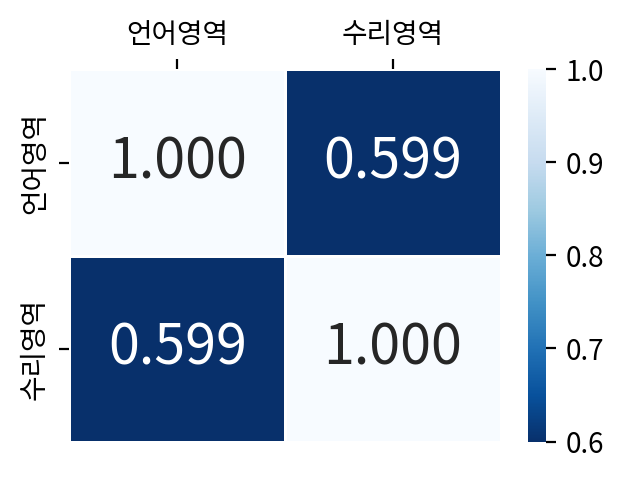

In [ ]:
width_px = 650
height_px = 500
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt="0.3f", linewidth=0.5, cmap="Blues_r", annot_kws={"size":20})


ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top() #X축의 변수 이름을 상단으로 이동                                                                                      




plt.tight_layout()
plt.show()
plt.close()

1. 피어슨 r 상관계수를 선택한 경우
본 분석에서는 언어영역과 수리영역 점수 간 상관관계를 검토하였다.
데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치의 영향도 크지 않아 피어슨 상관계수를 사용하였다.
분석 결과, 피어슨 상관계수는 r=0.671, p<.001로 나타나 두 변수 간 유의한 양의 상관관계가 존재함을 확인하였다.

2. 스피어만 r 상관계수를 선택한 경우
본 분석에서는 언어영역과 수리영역 점수 간 상관관계를 평가하였다.
데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 스피어만 상관계수를 사용하였다.
분석 결과, 스피어만 상관관계는 rho =0.599, p<.001 로 나타나 두 변수 간 유의한 양의 단조 관계가 존재함을 확인하였다.
